In [1]:
#loading the required libraries 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mahotas.features
import itertools
import math
from typing import Tuple, List
from PIL import Image
import os

In [2]:
def daugman(gray_img: np.ndarray, center: Tuple[int, int],start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:
        
        x, y = center
        intensities = []
        mask = np.zeros_like(gray_img)

        radii = list(range(start_r, end_r, step))  # type: List[int]
        for r in radii:

            cv2.circle(mask, center, r, 255, 1)

            diff = gray_img & mask
#             print(r)
#             print('Diff value:-',diff[diff>0])

            intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))
#             print(intensities)
            mask.fill(0)


        intensities_np = np.array(intensities, dtype=np.float32)
        del intensities

        intensities_np = intensities_np[:-1] - intensities_np[1:]
#         print("intensitiy value ",intensities_np)
       
        intensities_np = abs(cv2.GaussianBlur(intensities_np, (1, 5), 0))
#         print("Intensity values after applying gausssian blur function:",intensities_np)
        idx = np.argmax(intensities_np) 
#         print("max intensity",intensities_np[idx])
#         print("radius :-",radii[idx])

        return intensities_np[idx], radii[idx]
    
def find_iris(gray: np.ndarray,daugman_start: int, daugman_end: int,daugman_step: int = 1, points_step: int = 1,) -> Tuple[Tuple[int, int], int]:
   
    h, w = gray.shape
    if h != w:
        print('Your image is not a square!')
#     print("yes")
    single_axis_range = range(int(h / 3), h - int(h / 3), points_step)
    all_points = itertools.product(single_axis_range, single_axis_range)
    intensity_values = []
    coords = []  
    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
#         print("value:-",val)
#         print("radius:-",r)
        intensity_values.append(val)
        coords.append((point, r))
#     print("Intensity value:-",intensity_values)
#     print("Coordinates:-",coords)
    best_idx = intensity_values.index(max(intensity_values))
#     print("best :-",best_idx)
#     print("coordinates exact:-",coords[best_idx])
    return coords[best_idx]

['L2.JPG', 'L3.JPG', 'R2.JPG', 'R3.JPG']
C:\Users\DELL\Downloads\train_images_0-150\train_images_0-150\26\L2.JPG
iris coordinates (99, 101)
(1710, 1745)


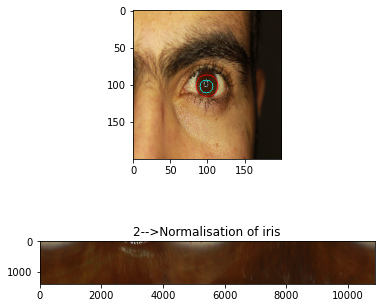

<Figure size 432x288 with 0 Axes>

C:\Users\DELL\Downloads\train_images_0-150\train_images_0-150\26\L3.JPG
iris coordinates (99, 101)
(1710, 1745)


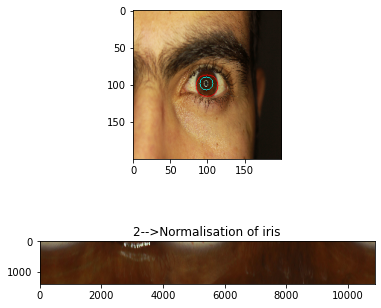

<Figure size 432x288 with 0 Axes>

C:\Users\DELL\Downloads\train_images_0-150\train_images_0-150\26\R2.JPG
iris coordinates (98, 99)
(1693, 1710)


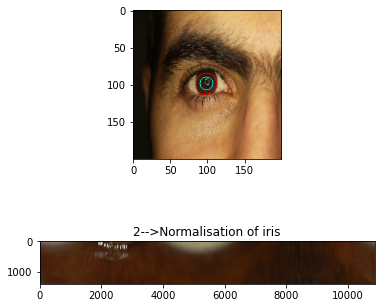

<Figure size 432x288 with 0 Axes>

C:\Users\DELL\Downloads\train_images_0-150\train_images_0-150\26\R3.JPG
iris coordinates (99, 101)
(1710, 1745)


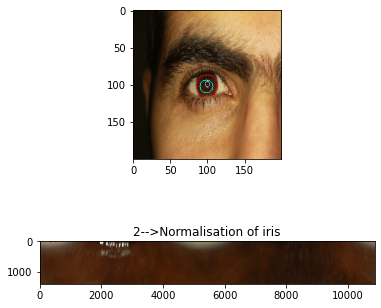

<Figure size 432x288 with 0 Axes>

In [3]:
root = 'C:\\Users\\DELL\\Downloads\\train_images_0-150\\train_images_0-150\\26'

pattern = ".JPG"

for path, subdirs, files in os.walk(root):
    
    print(files)
    for name in files:
        img = os.path.join(path, name)
        print(img)
        image = Image.open(img)
        color_coverted = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2GRAY)
        #changing the image size 
        dim_new = (200, 200) 
        res = cv2.resize(np.asarray(image), dim_new, interpolation = cv2.INTER_LINEAR)
        resize_img = cv2.resize(color_coverted, dim_new)
        
#         plt.imshow(resized_img)
        gray_img = resize_img
        
        
        
        #detecting iris
        iris = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=1)
        
        #detecting pupil
        pupil = find_iris(gray_img, daugman_start=9, daugman_end=30, daugman_step=4, points_step=4)
#         print(pupil)
        
        # setting the dimensions to the variables 
        pupil_center, pupil_radius = pupil
        iris_center, iris_radius = iris
        print("iris coordinates",iris_center)
        if pupil_radius == iris_radius:
            iris_radius +=1
            print(pupil_radius, iris_radius)
        
        size_new = (min(image.size),min(image.size))
        
        #Normailsation of iris
        hig_res = cv2.resize(np.asarray(image), size_new)
        multiplier = size_new[0]/res.shape[0]
#         print(multiplier)
        iris_center_norm = tuple(int(multiplier*elem) for elem in iris_center)
        print(iris_center_norm)
        conversion_img = cv2.warpPolar(hig_res, (size_new[0], int(size_new[0] * math.pi)), iris_center_norm, iris_radius * multiplier, 0)
        converted = cv2.rotate(conversion_img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        norm_img = converted[: int(converted.shape[0] * (1 - pupil_radius/iris_radius)), :]
        
        #drawing the circles with the dimensions to show the output
        pupil_img = cv2.circle(res, pupil_center, pupil_radius, (0, 255, 255), 1)
   
        iris_img = cv2.circle(pupil_img, iris_center, iris_radius, (255, 0, 0), 1)
        #plt.imshow(iris_img)
        
        f, fig = plt.subplots(2,1, figsize=(6,6)) 
        fig[0].imshow(iris_img)
        
        fig[1].imshow(norm_img)
        plt.title("2-->Normalisation of iris")
        plt.figure()
        plt.show()
     